<a href="https://colab.research.google.com/github/umbertogagl97/Attacks-ART/blob/main/Attacco_DeepFool_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [1]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 4.0 MB/s 
     |████████████████████████████████| 3.3 MB 28.1 MB/s 
     |████████████████████████████████| 26.3 MB 59.0 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


## Import librerie

In [2]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import time
#import os
#import shutil
#import copy

import pandas as pd
import matplotlib.pyplot as plt
import sys

from torchvision.transforms.functional import InterpolationMode

from torch.utils.data import TensorDataset, DataLoader

import cv2
from google.colab.patches import cv2_imshow

##Check device


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Transforms

In [4]:
transf_init=transforms.Resize(size=(1000,1000),interpolation=InterpolationMode.NEAREST)

data_transform_test= transforms.Compose([transforms.Resize([224,224]),
          #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

##Def path

In [5]:
#scanner
scanner_name = 'HiScan'

#salvataggio modello
#model_name = 'VGG19_10epoc_lr5_bs200_adam'
path_model = F"/content/gdrive/My Drive/ModelliCNN/Scanner/Final/{scanner_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

pd_preds_value=F'/content/gdrive/MyDrive/Dataset_impronte/test/Preds_value/{scanner_name}.xlsx'

##Collegamento google drive

In [6]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgSfHRTiTht9N1136oWWx19csI-otlhzew1P2EcVxHoKToa7jnR5AY
Mounted at /content/gdrive


#**Dataset**

##Caricamento dataset

In [7]:
test_dataset = datasets.ImageFolder(pathTestset,transforms.ToTensor())
dim_set=len(test_dataset)
print(dim_set)

2500


##Dataloader

In [8]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)
print(len(testgen))

2500


##Nomi classi

In [9]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)
#del test_dataset

['Live', 'Spoof']
2


#**Riduzione dataset**

In [10]:
test_dataset.samples=test_dataset.samples[1001:1002]

dim_set=len(test_dataset)
print(dim_set)

1


# **Creazione modello**

> non ho bloccato i parametri inferiori e sbloccato quelli del classificatore, vedi se funziona



##Load model pre-trained

In [11]:
model = models.vgg19(pretrained=True,progress=True)
#model = models.densenet201(pretrained=True,progress=True)
#print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

##Aggiunta classificatore

In [ ]:
model.classifier[6]=nn.Linear(4096,2) #per vgg19
#model.classifier=nn.Linear(1920,2) #per densenet201

#print(model) 

##Load pesi

In [13]:
model.load_state_dict(torch.load(path_model))#,map_location=torch.device('cpu')))


<All keys matched successfully>

# **Def funzioni**

##calc size

In [15]:
def calc_size(n):
  '''
  n: int 
  return: 80% of n
  '''
  return tuple(int(np.ceil(i * (80/100))) for i in n)

##Perturbazione

In [16]:
def compute_perturb(x,x_adv):
  '''
    x: img originali
    x_adv: img contraddittorie
    return: pertubazioni, media, perturbazioni normalizzate in [0,1] 
  '''
  perturb=x_adv-x
  m=np.mean(np.abs((x_adv - x)),axis=(1,2,3))
  #print('Average perturbation: {:4.2f}'.format(m))
  min, max = np.amin(perturb), np.amax(perturb)
  perturb_norm = (perturb - min) / (max - min)
  return perturb,m,perturb_norm

##Print subplot

In [17]:
def print_subplot(x_test,y_test,preds,x_test_adv,value_preds_adv,normalize=True):
  '''
    x_test: img originali
    y_test: classi originali
    preds: classi predette per img originali
    x_test_adv: img contraddittoria
    value_preds_adv: probabilità predette img contraddittorie
    normalize: se True normalizza le immagini
  '''
  
  if normalize:
    min,max=np.min(x_test),np.max(x_test)
    x_test = (x_test - min) / (max - min)
    min,max=np.min(x_test_adv),np.max(x_test_adv)
    x_test_adv = (x_test_adv - min) / (max - min)

  perturb,val_pert,perturb_norm=compute_perturb(x_test,x_test_adv)
  perturb[perturb<0]=0 #rimuovo i valori negativi poiché non posso visualizzarli

  #nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
  for i in range(len(x_test)):#(x_test.shape[0]):
    value=value_preds_adv[i]*100
    value_sorted=sorted(value,reverse=True)
    classes=[]
    for j in range(value.size) :
      ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
      classes.append(classes_name[ind[0][0]]) #classes è il vettore finale
    
    value_sorted=[ round(elem, 2) for elem in value_sorted ]

    #in seguito per ogni immagine del test set si stampa un subplot
    fig = plt.figure(figsize=[20,20])
    #plt.subplots_adjust(wspace=0.9)
    print('\033[1m'+"IMMAGINE "+'\033[1m',i) #valore END: '\033[0m'
    #originale
    ax1 = fig.add_subplot(131) #subplot con 3 righe e due colonne
    ax1.axis('off')
    #ax1.imshow(cv2.rotate(x_test[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax1.imshow(x_test[i].transpose(1,2,0))
    ax1.title.set_text("ORIGINALE\nclasse reale: "+classes_name[np.argmax(y_test[i])]+"\nclasse predetta: "+str(preds[i]))
    #perturbazione
    ax2 = fig.add_subplot(132)
    #ax2.imshow(cv2.rotate(perturb_norm[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax2.imshow(perturb[i].transpose(1,2,0),cmap='gray')
    ax2.axis('off')
    ax2.title.set_text("PERTURBAZIONE\nvalore medio: "+str(round(val_pert[i],4))+"\nmax: "+str(np.max(perturb[i]))+"\nmin: "+str(np.min(perturb[i])))
    #perturbata
    ax3 = fig.add_subplot(133)
    #ax3.imshow(cv2.rotate(x_test_adv[i],cv2.cv2.ROTATE_90_CLOCKWISE))#,aspect='auto')
    ax3.imshow(x_test_adv[i].transpose(1,2,0))
    ax3.axis('off')
    ax3.title.set_text("PERTURBATA\nclassi predette: "+str(classes)+"\ncon valori: "+str(value_sorted))
    plt.show()

##Testing

con media senza datframe

In [18]:
def test_average_preds(classifier,input):
  '''
  model: model trained
  test_loader: dataloader 
  return: pred: classe predetta, probabilities: probabilità per entrambe le classi
  '''
  preds=[]
  #value=[]
  prob=nn.Softmax()
  data_transform_test= transforms.Compose([transforms.Resize([224,224]),
          #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
  
  if input.shape[2]!=1000:
    input=transf_init(input)

  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
  crops=crop_transform(input)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop) #resize 224
    outputs = classifier.predict(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  predicted=np.argmax([live,spoof])
  probabilities=prob(torch.Tensor([live,spoof])).numpy()

  return predicted,probabilities

In [19]:
def test_average_values(classifier,input):
  '''
  model: model trained
  test_loader: dataloader 
  return: pred: classe predetta, probabilities: probabilità per entrambe le classi
  '''
  preds=[]
  #value=[]
  data_transform_test= transforms.Compose([transforms.Resize([224,224]),
          #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
  
  if input.shape[2]!=1000:
    input=transf_init(input)

  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
  crops=crop_transform(input)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop) #resize 224
    outputs = classifier.predict(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  predicted=np.argmax([live,spoof])
  values=[live,spoof]

  return predicted,values

##Array to dataloader

In [20]:
def array2dataloader(x,y):
  '''
  :param x: ndarray x_test;
  :param y: labels
  '''
  tensor_x = torch.Tensor(x) # transform to torch tensor
  tensor_y = torch.Tensor(np.argmax(y,axis=1))

  my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  return DataLoader(my_dataset) 

##mask

In [21]:
def compute_mask(img):
  #img iniziale [0,1]
  img=np.array(img[0])
  img=img.transpose(1,2,0)

  #trasforma in gray
  r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  #scala in [0,255]
  gray = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
  gray=gray*255
  gray=gray.astype('uint8')
  #calcola immagine binaria
  ret, imgf = cv2.threshold(gray, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  image_contours = np.zeros((imgf.shape[1],
                            imgf.shape[0]),
                            np.uint8)

  image_binary = np.zeros((imgf.shape[1],
                          imgf.shape[0]),
                          np.uint8)

  #cerca i contorni nell'immagine binaria
  contours =cv2.findContours(imgf, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
  cv2.drawContours(image_contours,
                      contours, -1,
                      (255,255), 3)

  contours = cv2.findContours(image_contours, cv2.RETR_LIST,
                            cv2.CHAIN_APPROX_SIMPLE)[0]
  #disegna solo il contorno più esterno
  cv2.drawContours(image_binary, [max(contours, key = cv2.contourArea)],
                  -1, (255, 255),-1)
  #restituisce immagine [0,1]
  return ((image_binary-np.min(image_binary))/(np.max(image_binary)-np.min(image_binary)))

##DeepFool

In [60]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional, TYPE_CHECKING

import numpy as np
from tqdm.auto import trange

from art.config import ART_NUMPY_DTYPE
from art.estimators.estimator import BaseEstimator
from art.estimators.classification.classifier import ClassGradientsMixin
from art.attacks.attack import EvasionAttack
from art.utils import compute_success, is_probability

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)


class DeepFool_mod(EvasionAttack):
    """
    Implementation of the attack from Moosavi-Dezfooli et al. (2015).
    | Paper link: https://arxiv.org/abs/1511.04599
    """

    attack_params = EvasionAttack.attack_params + [
        "max_iter",
        "epsilon",
        "nb_grads",
        "batch_size",
        "verbose",
    ]
    _estimator_requirements = (BaseEstimator, ClassGradientsMixin)

    def __init__(
        self,
        classifier: "CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE",
        max_iter: int = 100,
        epsilon: float = 1e-6,
        nb_grads: int = 10,
        batch_size: int = 1,
        verbose: bool = True,
    ) -> None:
        """
        Create a DeepFool attack instance.
        :param classifier: A trained classifier.
        :param max_iter: The maximum number of iterations.
        :param epsilon: Overshoot parameter.
        :param nb_grads: The number of class gradients (top nb_grads w.r.t. prediction) to compute. This way only the
                         most likely classes are considered, speeding up the computation.
        :param batch_size: Batch size
        :param verbose: Show progress bars.
        """
        super().__init__(estimator=classifier)
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.nb_grads = nb_grads
        self.batch_size = batch_size
        self.verbose = verbose
        self._check_params()
        if self.estimator.clip_values is None:
            logger.warning(
                "The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by "
                "default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip "
                "the adversarial example."
            )

    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, class_target=0, confidence=0.6, **kwargs) -> np.ndarray:
        """
        Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs to be attacked.
        :param y: An array with the original labels to be predicted.
        :return: An array holding the adversarial examples.
        """
        x_adv = x.astype(ART_NUMPY_DTYPE)
        
        prob=nn.Softmax()
        #preds = self.estimator.predict(x, batch_size=self.batch_size)

        class_pred,preds=test_average_values(self.estimator,torch.Tensor(x_adv))
        preds=np.array(preds)

        if self.estimator.nb_classes == 2 and preds.shape == 1:
            raise ValueError(
                "This attack has not yet been tested for binary classification with a single output classifier."
            )

        if is_probability(preds[0]):
            logger.warning(
                "It seems that the attacked model is predicting probabilities. DeepFool expects logits as model output "
                "to achieve its full attack strength."
            )

        # Determine the class labels for which to compute the gradients
        use_grads_subset = self.nb_grads < self.estimator.nb_classes
        if use_grads_subset:
            # TODO compute set of unique labels per batch
            grad_labels = np.argsort(-preds, axis=1)[:, : self.nb_grads]
            labels_set = np.unique(grad_labels)
        else:
            labels_set = np.arange(self.estimator.nb_classes)
        sorter = np.arange(len(labels_set))

        # Pick a small scalar to avoid division by 0
        tol = 10e-8

        # Compute perturbation with implicit batching
        for batch_id in trange(
            int(np.ceil(x_adv.shape[0] / float(self.batch_size))), desc="DeepFool", disable=not self.verbose
        ):
            batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
            batch = x_adv[batch_index_1:batch_index_2].copy()

            # Get predictions and gradients for batch
            #f_batch = preds[batch_index_1:batch_index_2] #predizioni
            #fk_hat = np.argmax(f_batch, axis=1) #classe predetta
            if use_grads_subset:
                # Compute gradients only for top predicted classes
                grd = np.array([self.estimator.class_gradient(batch, label=_) for _ in labels_set])
                grd = np.squeeze(np.swapaxes(grd, 0, 2), axis=0)
            else:
                # Compute gradients for all classes
                grd = self.estimator.class_gradient(batch)

            # Get current predictions
            if ((class_pred==np.argmax(y, axis=1)) and (class_pred!= class_target)):
              active=True
            elif ((class_pred!=np.argmax(y, axis=1)) and (class_pred== class_target) and (np.max(prob(torch.Tensor(preds)).numpy())<confidence)): 
              active=True
            else:  active=False
            #active_indices = np.arange(len(batch))
            current_step = 0
            while active==True and current_step < self.max_iter:
                # Compute difference in predictions and gradients only for selected top predictions
                labels_indices = sorter[np.searchsorted(labels_set, class_pred, sorter=sorter)]
                grad_diff = grd - grd[np.arange(len(grd)), labels_indices][:, None]
                f_diff = preds[labels_set] - preds[labels_indices]

                # Choose coordinate and compute perturbation
                norm = np.linalg.norm(grad_diff.reshape(len(grad_diff), len(labels_set), -1), axis=2) + tol
                value = np.abs(f_diff) / norm
                value[np.arange(len(value)), labels_indices] = np.inf
                l_var = np.argmin(value, axis=1)
                absolute1 = abs(f_diff[l_var])
                draddiff = grad_diff[np.arange(len(grad_diff)), l_var].reshape(len(grad_diff), -1)
                pow1 = (
                    pow(
                        np.linalg.norm(draddiff, axis=1),
                        2,
                    )
                    + tol
                )
                r_var = absolute1 / pow1
                r_var = r_var.reshape((-1,) + (1,) * (len(x.shape) - 1))
                r_var = r_var * grad_diff[np.arange(len(grad_diff)), l_var]

                # Add perturbation and clip result
                if self.estimator.clip_values is not None:
                    batch = np.clip(
                        batch
                        + r_var * (self.estimator.clip_values[1] - self.estimator.clip_values[0]),
                        self.estimator.clip_values[0],
                        self.estimator.clip_values[1],
                    )
                else:
                    batch += r_var

                # Recompute prediction for new x
                class_pred_i,preds=test_average_values(self.estimator,torch.Tensor(x_adv))
                preds=np.array(preds)
                #f_batch = self.estimator.predict(batch)
                #fk_i_hat = np.argmax(f_batch, axis=1)

                # Recompute gradients for new x
                if use_grads_subset:
                    # Compute gradients only for (originally) top predicted classes
                    grd = np.array([self.estimator.class_gradient(batch, label=_) for _ in labels_set])
                    grd = np.squeeze(np.swapaxes(grd, 0, 2), axis=0)
                else:
                    # Compute gradients for all classes
                    grd = self.estimator.class_gradient(batch)

                # Stop if misclassification has been achieved
                #active_indices = np.where(class_pred_i == class_pred)[0]
                if ((class_pred_i==np.argmax(y, axis=1)) and (class_pred_i!= class_target)):
                  active=True
                elif ((class_pred_i!=np.argmax(y, axis=1)) and (class_pred_i== class_target) and (np.max(prob(torch.Tensor(preds)).numpy())<confidence)): 
                  active=True
                else:  active=False

                current_step += 1

            # Apply overshoot parameter
            x_adv1 = x_adv[batch_index_1:batch_index_2]
            x_adv2 = (1 + self.epsilon) * (batch - x_adv[batch_index_1:batch_index_2])
            x_adv[batch_index_1:batch_index_2] = x_adv1 + x_adv2
            if self.estimator.clip_values is not None:
                np.clip(
                    x_adv[batch_index_1:batch_index_2],
                    self.estimator.clip_values[0],
                    self.estimator.clip_values[1],
                    out=x_adv[batch_index_1:batch_index_2],
                )

        logger.info(
            "Success rate of DeepFool attack: %.2f%%",
            100 * compute_success(self.estimator, x, y, x_adv, batch_size=self.batch_size),
        )
        return x_adv

    def _check_params(self) -> None:
        if not isinstance(self.max_iter, (int, np.int)) or self.max_iter <= 0:
            raise ValueError("The number of iterations must be a positive integer.")

        if not isinstance(self.nb_grads, (int, np.int)) or self.nb_grads <= 0:
            raise ValueError("The number of class gradients to compute must be a positive integer.")

        if self.epsilon < 0:
            raise ValueError("The overshoot parameter must not be negative.")

        if self.batch_size <= 0:
            raise ValueError("The batch size `batch_size` has to be positive.")

        if not isinstance(self.verbose, bool):
            raise ValueError("The argument `verbose` has to be of type bool.")

# **Esecuzione**

##Creazione classificatore ART Pytorch



In [23]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr=1e-5),
    input_shape=(224, 224, 3),
    nb_classes=class_number
)

##Attacco

In [61]:
from art.utils import to_categorical
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
# FGM
attack = DeepFool_mod(classifier,epsilon=0.001,max_iter=10,nb_grads=2)

list_print=sorted(random.sample(range(dim_set),1))

x_print=[]
y_print=[]
x_print_adv=[] 
y_print_adv=[] 
Test_p = pd.DataFrame()
model.eval()
model.cuda()
data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
i=0
for input,label in testgen:
  i+=1

  sys.stdout.write("\rElem: {0}/{1}".format(i,len(testgen)))
  sys.stdout.flush()
  
  #input=data_transform_test(input) #prima faccio resize a 224 per calcolare le adv

  y_test=np.array((to_categorical(label.numpy(),2)))
  x_test=np.array(input.numpy())

  x_test_adv=attack.generate(x=x_test,y=y_test,class_target=classes_name.index('Live'),confidence=0.7)[0,:,:,:]
  
  x_test_adv=torch.Tensor(x_test_adv)
  x_test_adv=x_test_adv.unsqueeze_(0)
  
  if x_test_adv.shape[2]!=1000:
    x_test_adv=transf_init(x_test_adv)

  pred,probabilities=test_average_preds(classifier,x_test_adv)
  Test_p = Test_p.append({'real': classes_name[int(label)] ,
                          'predicted': classes_name[pred], #qui metti pred
                          'prob_live': round(probabilities[0],4),
                          'prob_spoof': round(probabilities[1],4)},ignore_index = True)

  #print
  if i-1 in list_print:
    x_print.append(x_test[0])
    x_print_adv.append(x_test_adv[0].numpy())
    y_print.append(y_test)
    y_print_adv.append(probabilities)


Elem: 1/1

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: ignored

##Testing

> Trasforma i due testing in una funzione e richiamala due volte



###Print accuracy test orig from file & load pd

In [ ]:
Test_orig=pd.read_excel(pd_preds_value)
true_label = Test_orig.real.values
predicted = Test_orig.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test_orig.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test_orig.shape))  


Accuracy: 94.92
Shape dataframe: (2500, 4)


###Testing immagini spoof predette live prima e dopo

####Accuracy adv

In [ ]:
true_label = Test_p.real.values
predicted = Test_p.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test_p.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test_p.shape)) 


Accuracy: 37.28
Shape dataframe: (2500, 4)


####Spoof

In [ ]:
print(Test_orig)
n_spoof=np.sum(Test_orig['real']=='Spoof')
print("# img spoof: "+str(n_spoof))

     predicted   real  value_pred_live  value_pred_spoof
0         Live   Live     9.999975e-01      2.466650e-06
1         Live   Live     9.965458e-01      3.454167e-03
2         Live   Live     9.999992e-01      8.817851e-07
3         Live   Live     1.000000e+00      1.178422e-08
4         Live   Live     9.999968e-01      3.219343e-06
...        ...    ...              ...               ...
2495     Spoof  Spoof     6.620399e-06      9.999933e-01
2496     Spoof  Spoof     2.302027e-07      9.999998e-01
2497     Spoof  Spoof     8.690116e-06      9.999913e-01
2498     Spoof  Spoof     4.773208e-07      9.999995e-01
2499     Spoof  Spoof     2.115458e-08      1.000000e+00

[2500 rows x 4 columns]
# img spoof: 1500


prima

In [ ]:
p=Test_orig.loc[Test_orig['real']=='Spoof']
p1=p.loc[p['predicted']==p['real']]
print("Img realmente spoof e predette spoof")
print(p1)
n_spoof_pred=p1.count(0)[0]
print("Numero di predizioni spoof giuste: "+str(n_spoof_pred))
print("Accuracy su img spoof: "+str(round(n_spoof_pred/n_spoof*100,2)))

Img realmente spoof e predette spoof
     predicted   real  value_pred_live  value_pred_spoof
1000     Spoof  Spoof     7.468125e-06          0.999992
1001     Spoof  Spoof     4.158686e-05          0.999958
1002     Spoof  Spoof     6.200246e-06          0.999994
1003     Spoof  Spoof     4.026251e-01          0.597375
1004     Spoof  Spoof     2.343990e-06          0.999998
...        ...    ...              ...               ...
2495     Spoof  Spoof     6.620399e-06          0.999993
2496     Spoof  Spoof     2.302027e-07          1.000000
2497     Spoof  Spoof     8.690116e-06          0.999991
2498     Spoof  Spoof     4.773208e-07          1.000000
2499     Spoof  Spoof     2.115458e-08          1.000000

[1443 rows x 4 columns]
Numero di predizioni spoof giuste: 1443
Accuracy su img spoof: 96.2


dopo

In [ ]:
d=Test_p.loc[Test_p['real']=='Spoof']
d1=d.loc[d['predicted']==d['real']]
print("Img realmente spoof e predette spoof")
print(d1)
n_spoof_pred2=d1.count(0)[0]
print("Numero di predizioni spoof giuste: "+str(n_spoof_pred2))
print("Accuracy su img spoof: "+str(round(n_spoof_pred2/n_spoof*100,2)))

Img realmente spoof e predette spoof
     predicted  prob_live  prob_spoof   real
2385     Spoof        0.0         1.0  Spoof
2395     Spoof        0.0         1.0  Spoof
Numero di predizioni spoof giuste: 2
Accuracy su img spoof: 0.13


####Live

In [ ]:
print(Test_orig)
n_live=np.sum(Test_orig['real']=='Live')
print("# img live: "+str(n_live))

     predicted   real  value_pred_live  value_pred_spoof
0         Live   Live     9.999975e-01      2.466650e-06
1         Live   Live     9.965458e-01      3.454167e-03
2         Live   Live     9.999992e-01      8.817851e-07
3         Live   Live     1.000000e+00      1.178422e-08
4         Live   Live     9.999968e-01      3.219343e-06
...        ...    ...              ...               ...
2495     Spoof  Spoof     6.620399e-06      9.999933e-01
2496     Spoof  Spoof     2.302027e-07      9.999998e-01
2497     Spoof  Spoof     8.690116e-06      9.999913e-01
2498     Spoof  Spoof     4.773208e-07      9.999995e-01
2499     Spoof  Spoof     2.115458e-08      1.000000e+00

[2500 rows x 4 columns]
# img live: 1000


prima

In [ ]:
p=Test_orig.loc[Test_orig['real']=='Live']
p1=p.loc[p['predicted']==p['real']]
print("Img realmente live e predette live")
print(p1)
n_live_pred=p1.count(0)[0]
print("Numero di predizioni live giuste: "+str(n_live_pred))
print("Accuracy su img live: "+str(round(n_live_pred/n_live*100,2)))

Img realmente live e predette live
    predicted  real  value_pred_live  value_pred_spoof
0        Live  Live         0.999997      2.466650e-06
1        Live  Live         0.996546      3.454167e-03
2        Live  Live         0.999999      8.817851e-07
3        Live  Live         1.000000      1.178422e-08
4        Live  Live         0.999997      3.219343e-06
..        ...   ...              ...               ...
993      Live  Live         0.997092      2.908215e-03
994      Live  Live         0.649311      3.506885e-01
995      Live  Live         0.899581      1.004193e-01
998      Live  Live         0.521490      4.785097e-01
999      Live  Live         0.990239      9.761168e-03

[930 rows x 4 columns]
Numero di predizioni live giuste: 930
Accuracy su img live: 93.0


dopo

In [ ]:
d=Test_p.loc[Test_p['real']=='Live']
d1=d.loc[d['predicted']==d['real']]
print("Img realmente live e predette live")
print(d1)
n_live_pred2=d1.count(0)[0]
print("Numero di predizioni live giuste: "+str(n_live_pred2))
print("Accuracy su img live: "+str(round(n_live_pred2/n_live*100,2)))

Img realmente live e predette live
    predicted  prob_live  prob_spoof  real
0        Live     1.0000      0.0000  Live
1        Live     0.9965      0.0035  Live
2        Live     1.0000      0.0000  Live
3        Live     1.0000      0.0000  Live
4        Live     1.0000      0.0000  Live
..        ...        ...         ...   ...
993      Live     0.9971      0.0029  Live
994      Live     0.6493      0.3507  Live
995      Live     0.8996      0.1004  Live
998      Live     0.5215      0.4785  Live
999      Live     0.9902      0.0098  Live

[930 rows x 4 columns]
Numero di predizioni live giuste: 930
Accuracy su img live: 93.0


##subplot

In [ ]:
print(list_print)

[121, 156, 176, 226, 506, 557, 628, 734, 939, 980, 1009, 1072, 1126, 1333, 1348, 1741, 2039, 2180, 2375, 2463]


In [ ]:
x_print=np.array(x_print)
y_print=np.array(y_print)
x_print_adv=np.array(x_print_adv)
y_print_adv=np.array(y_print_adv)

In [ ]:
print(x_print_adv.shape)

(20, 3, 1000, 1000)


['Live' 'Live' 'Live' 'Live' 'Live' 'Live' 'Spoof' 'Live' 'Live' 'Live'
 'Spoof' 'Spoof' 'Spoof' 'Spoof' 'Spoof' 'Spoof' 'Spoof' 'Spoof' 'Spoof'
 'Spoof']
IMMAGINE  0


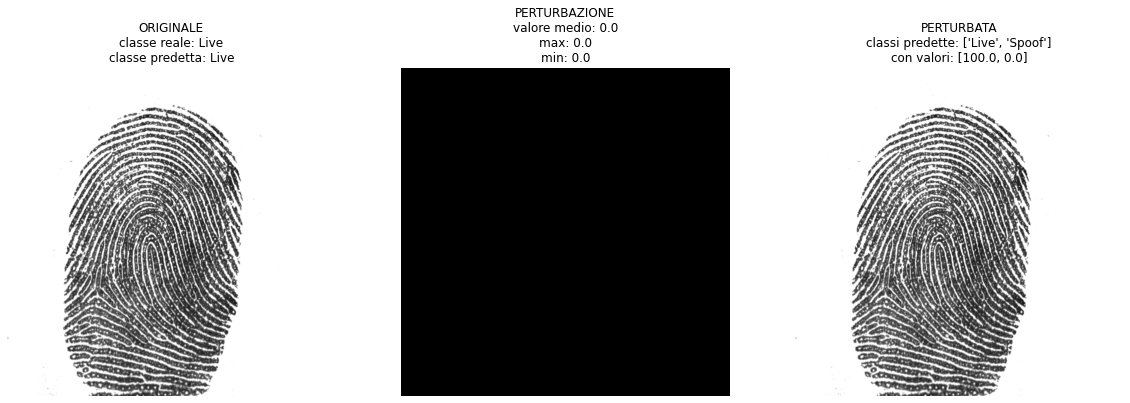

IMMAGINE  1


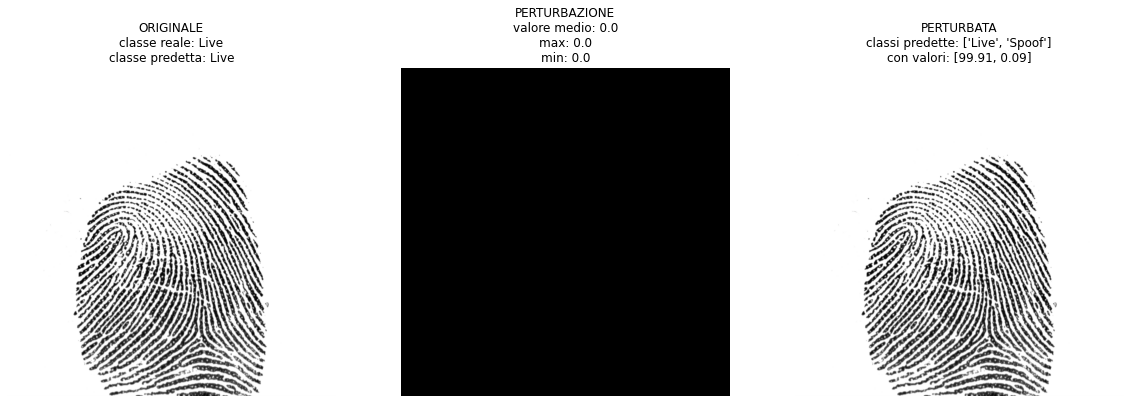

IMMAGINE  2


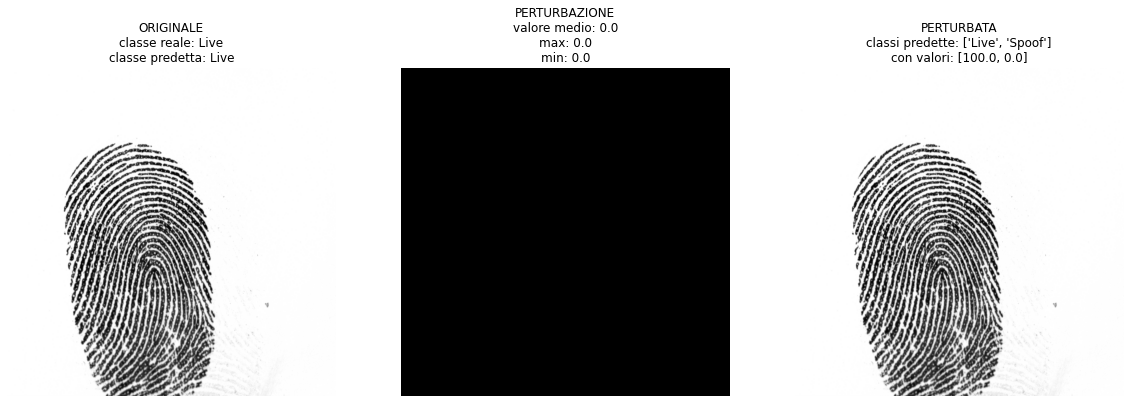

IMMAGINE  3


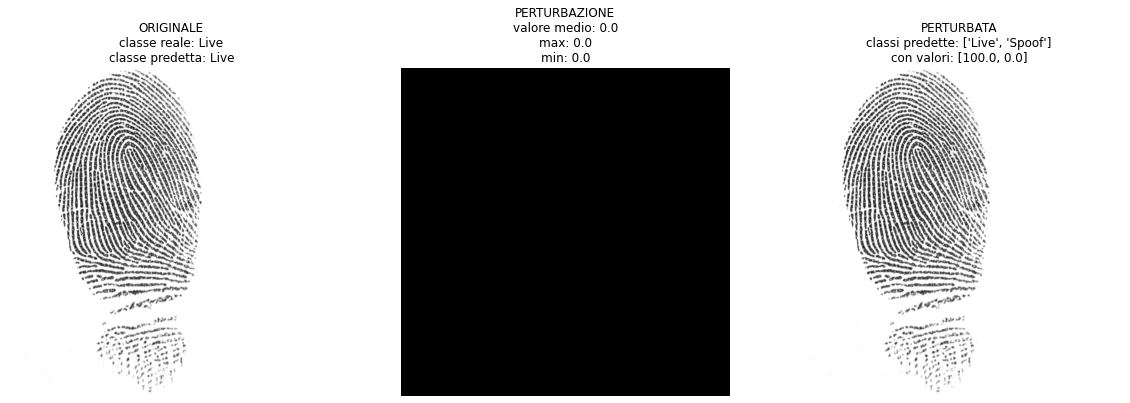

IMMAGINE  4


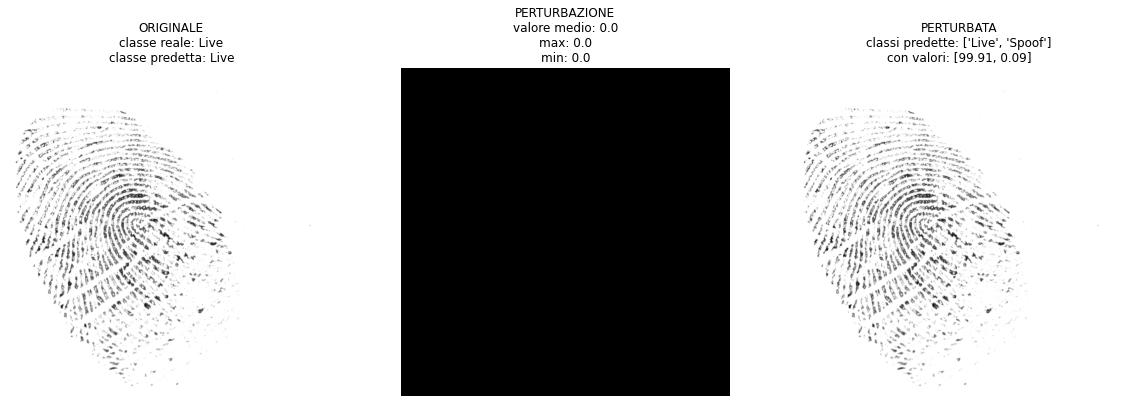

IMMAGINE  5


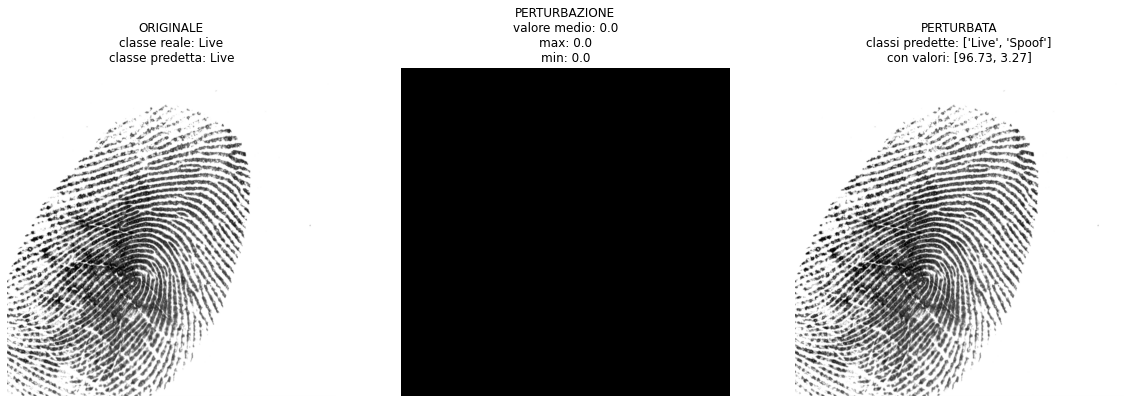

IMMAGINE  6


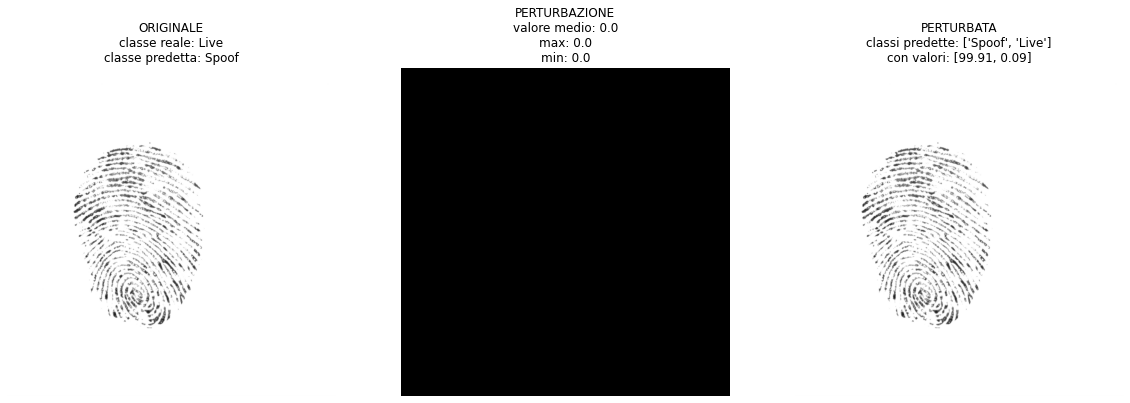

IMMAGINE  7


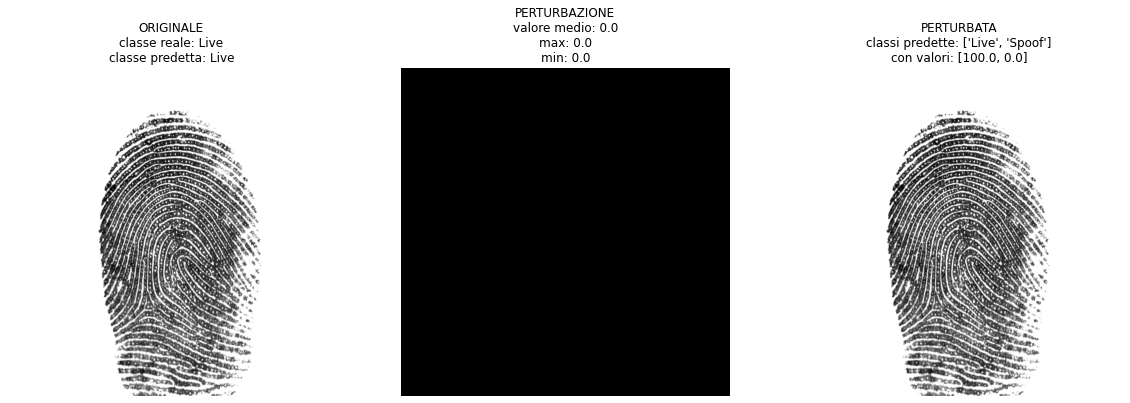

IMMAGINE  8


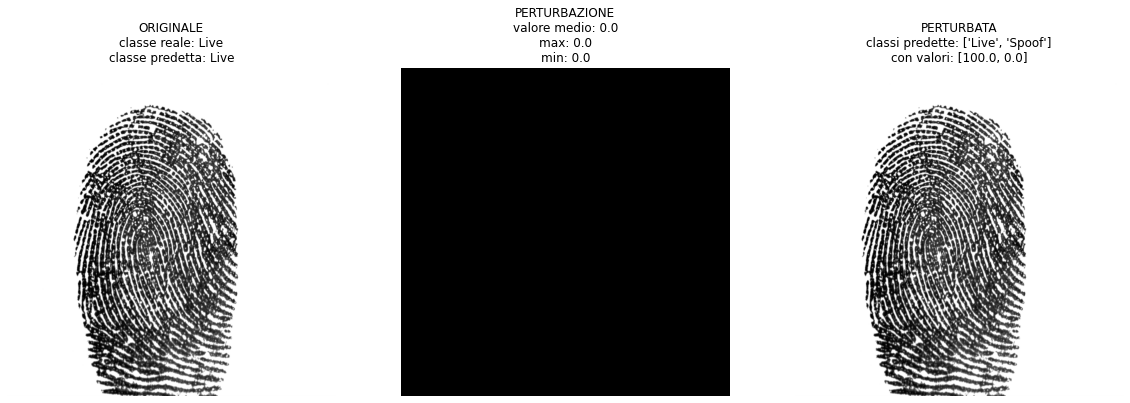

IMMAGINE  9


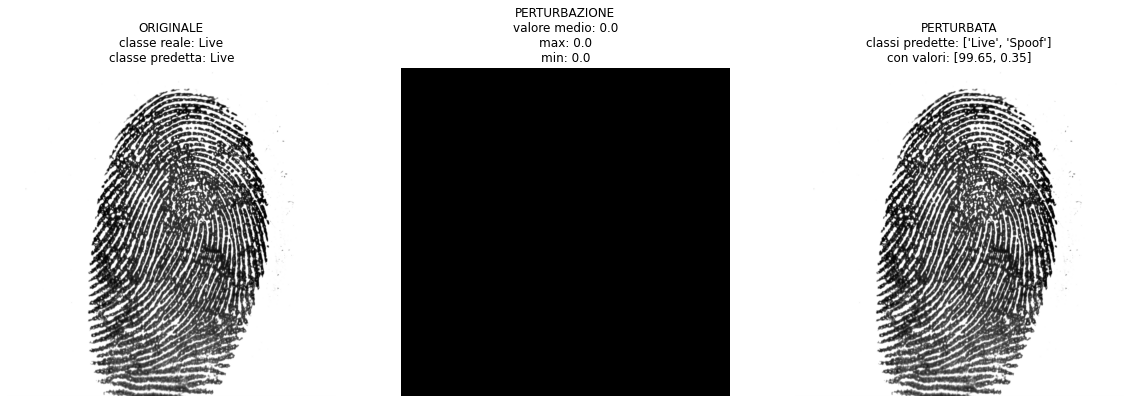

IMMAGINE  10


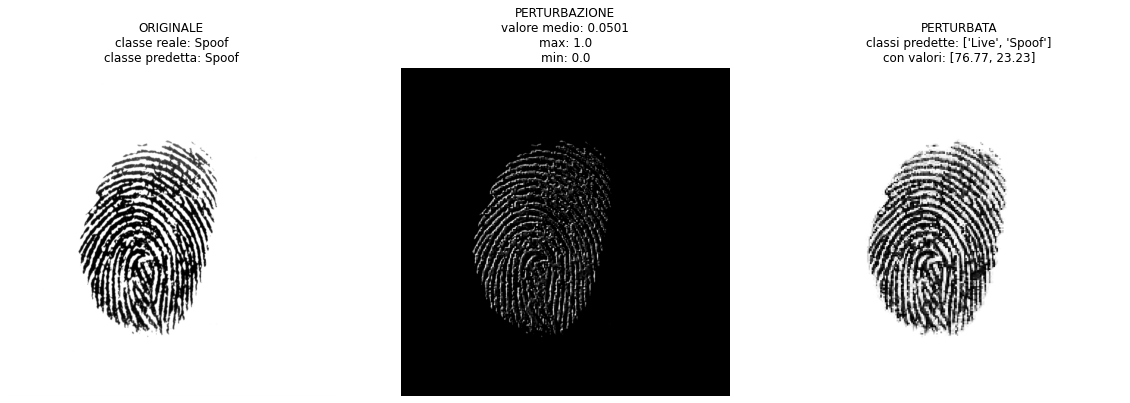

IMMAGINE  11


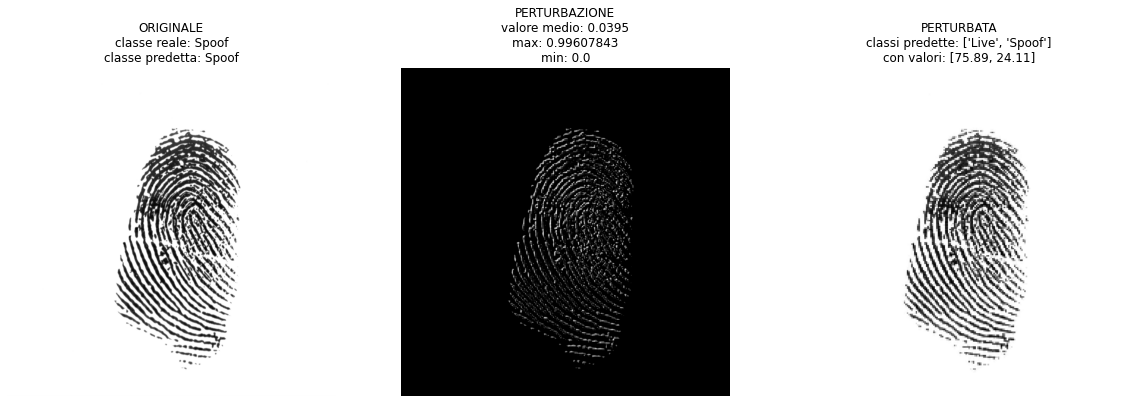

IMMAGINE  12


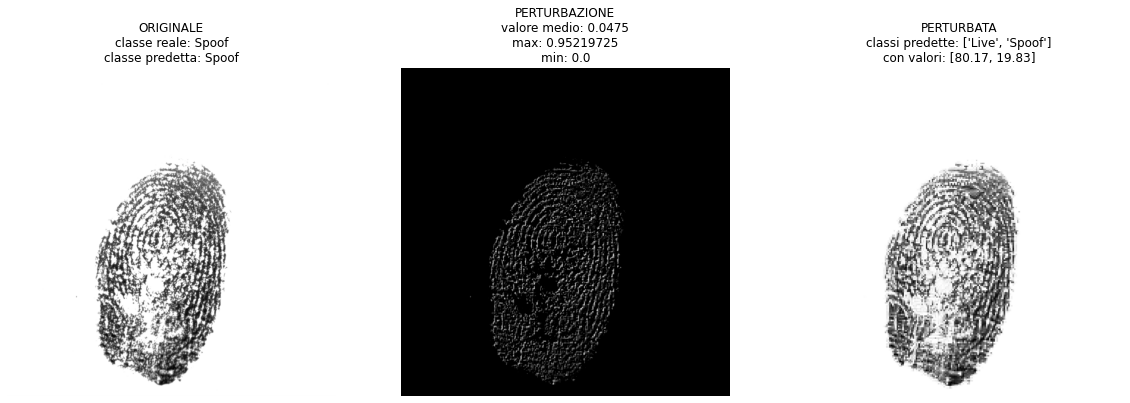

IMMAGINE  13


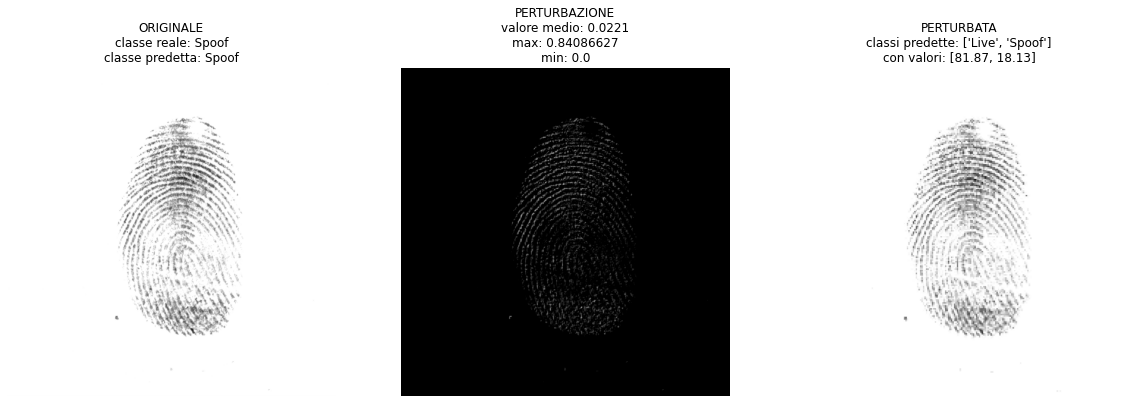

IMMAGINE  14


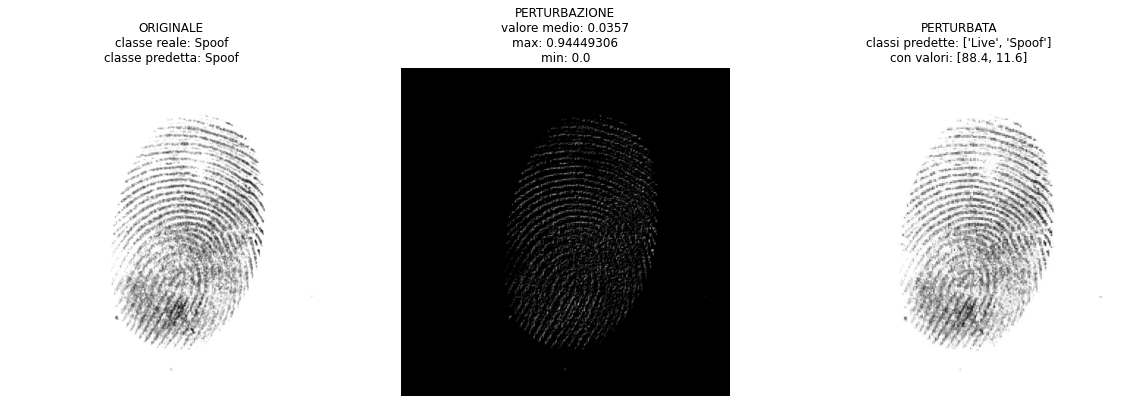

IMMAGINE  15


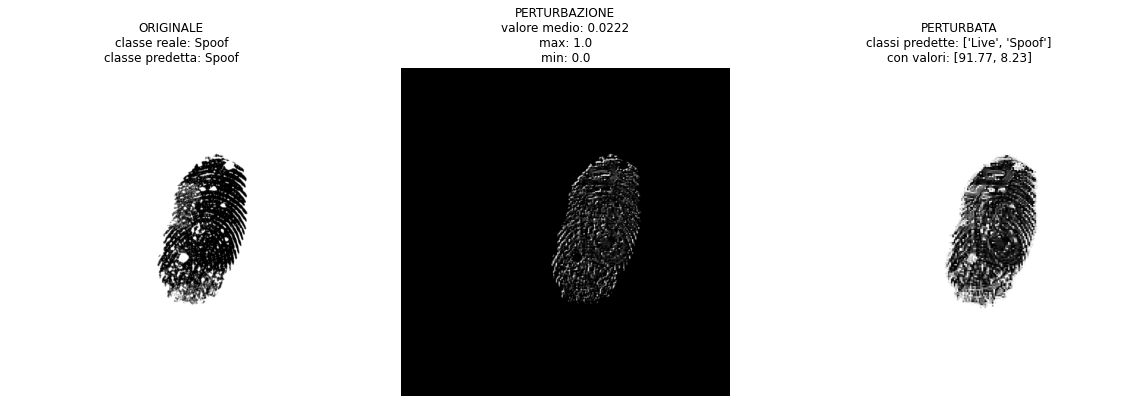

IMMAGINE  16


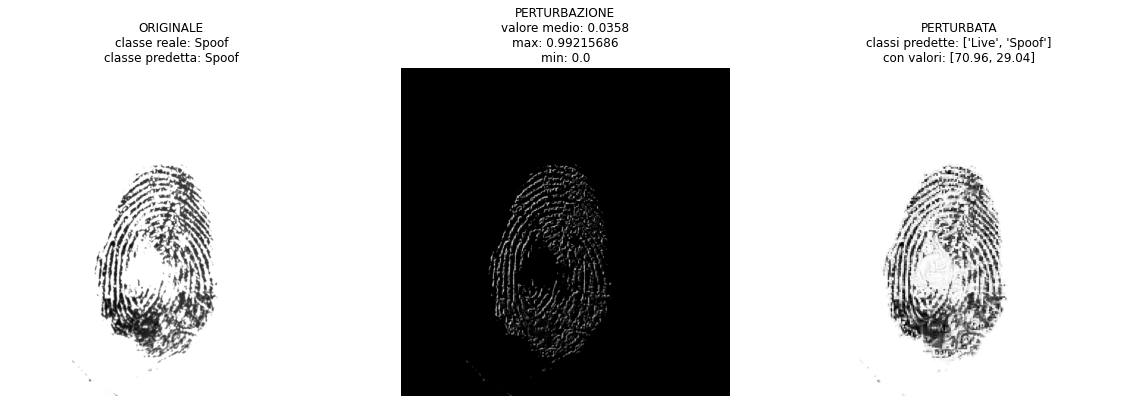

IMMAGINE  17


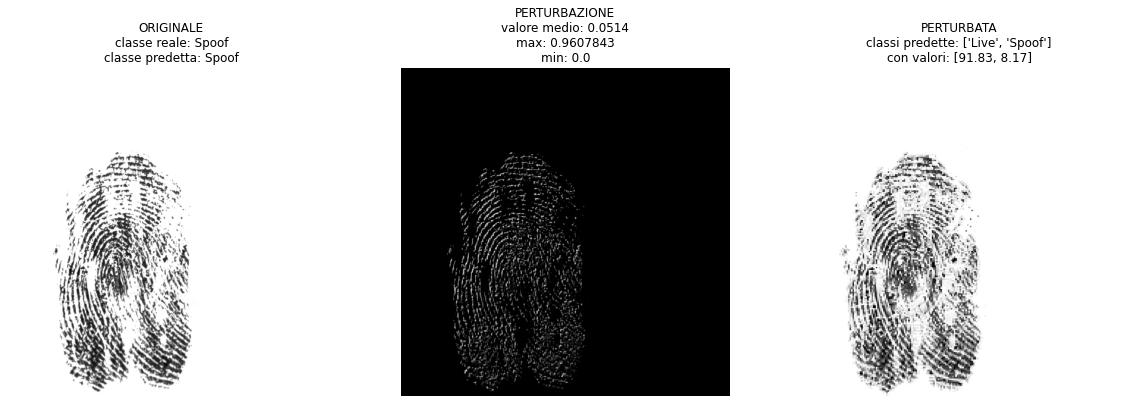

IMMAGINE  18


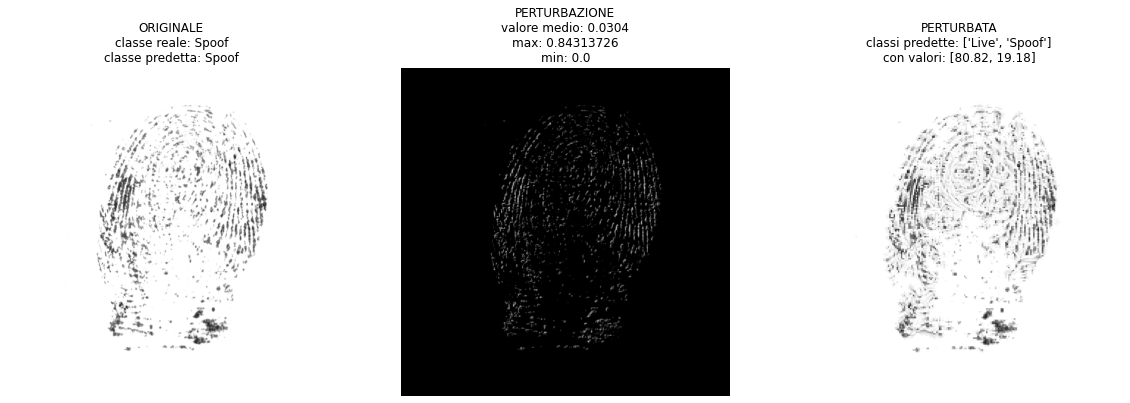

IMMAGINE  19


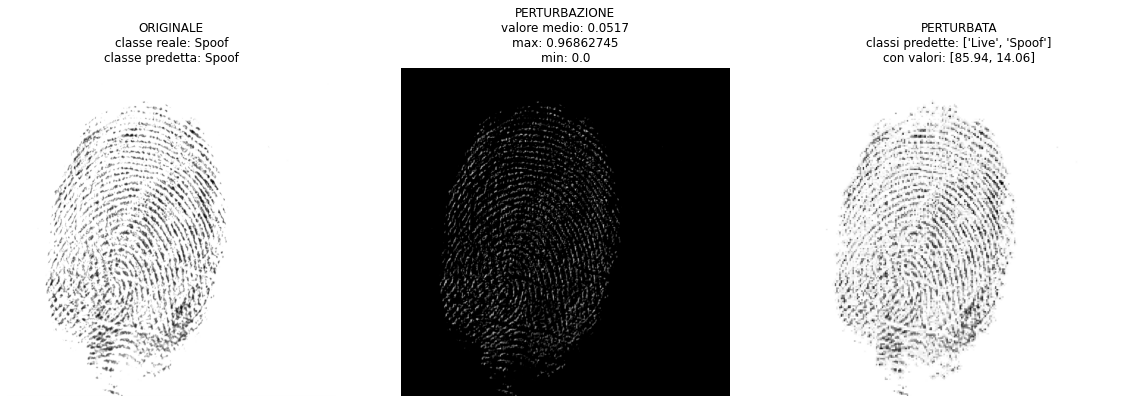

In [ ]:
#da usare nel test finale
preds_orig=Test_orig.predicted.values[list_print]
print(preds_orig)
print_subplot(x_print,y_print,preds_orig,x_print_adv,y_print_adv,normalize=False)

In [ ]:
#da usare solo con dataset ridotto
preds_orig=[]
for input,_ in testgen:
  preds_orig_i,_=test_average_preds(classifier,input)
  preds_orig.append(preds_orig_i)
preds_orig=np.array(preds_orig)
preds_orig=preds_orig[list_print]
print_subplot(x_print,y_print,preds_orig,x_print_adv,y_print_adv,normalize=False)

#prova salvataggio e lettura immagine

0 255


(0, array([ 2.8370285, -1.5031711], dtype=float32))

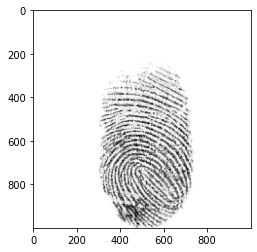

In [ ]:
from PIL import Image
arr_init=np.array(x_print_adv[i]).transpose(1,2,0)
arr_init=(arr_init-np.min(arr_init))/(np.max(arr_init)-np.min(arr_init))
print(np.min(arr_init),np.max(arr_init))
plt.imsave('prova.bmp',arr_init)
plt.imshow(arr_init)
test_average_values(classifier,torch.Tensor(x_print_adv[i]).unsqueeze_(0))

0 255


(0, array([ 2.8370285, -1.5031711], dtype=float32))

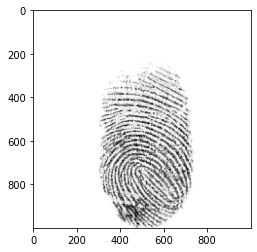

In [ ]:
prova_arr=plt.imread('prova.bmp')
prova_arr=(prova_arr-np.min(prova_arr))/(np.max(prova_arr)-np.min(prova_arr))
print(np.min(prova_arr),np.max(prova_arr))
plt.imshow(prova_arr)
test_average_values(classifier,torch.Tensor(prova_arr.transpose(2,0,1)).unsqueeze_(0))